In [2]:
"""
本文教程： https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/
这篇教程主要讲了如下几件事情：
1.bert 模型的分类情况
2.tokenizer,model 的初始化方式。可以根据自己的需要题换分词器和模型。
tokenizer 需要的是词表；而model需要的是模型
3.
"""
import torch
# 01.这里的BertTokenizer 就是一个Tokenizer。这个是BERT自己提供的。【说明可能也有别的
# 包提供】
# 02.BertModel 没有一个具体的输出任务，它的任务就是做一个embedding 
# 03.导入预训练的BERT tokenizer 和 BERT model。这个BERT model 是由谷歌发布的
# 预训练模型
from transformers import BertTokenizer, BertModel  

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Load pre-trained model tokenizer (vocabulary)
# 但是下载得到的文件地址在哪里？
# calling from_pretrained will fetch the model from the internet
"""
transformers provides a number of classes for applying BERT to different tasks 
(token classification, text classification, …)
"""
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

text = "Here is the sentence I want embeddings for."
# 因为BERT是一个预训练的模型，它期待输入数据都有固定的格式，所以下面这里有一个[cls] 和一个[sep]
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
# braking the text into tokens
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', 'here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.', '[SEP]']


In [4]:
list(tokenizer.vocab.keys())[5000:5020]  # 运行结果是固定的

['knight',
 'lap',
 'survey',
 'ma',
 '##ow',
 'noise',
 'billy',
 '##ium',
 'shooting',
 'guide',
 'bedroom',
 'priest',
 'resistance',
 'motor',
 'homes',
 'sounded',
 'giant',
 '##mer',
 '150',
 'scenes']

In [5]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "After stealing money from the bank vault, \
the bank robber was seen fishing on the Mississippi river bank."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# print out the tokens
print(tokenized_text)

['[CLS]', 'after', 'stealing', 'money', 'from', 'the', 'bank', 'vault', ',', 'the', 'bank', 'robber', 'was', 'seen', 'fishing', 'on', 'the', 'mississippi', 'river', 'bank', '.', '[SEP]']


In [6]:
# Map the token strings to their vocabulary indeces.
# 思考为什么要这么做？ 为什么要把token 转为id? => 因为只有这样才能进行后面的数学计算
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
# zip函数的作用是将两个list对应打包成tuple
# 可以看到，我们有两个‘bank’，但是它们的含义却大不相同
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))


[CLS]           101
after         2,044
stealing     11,065
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


In [7]:
# Mark each of the 22 tokens as belonging to sentence "1"
segments_ids = [1] * len(tokenized_text)
print(segments_ids)
# 但是疑问的是：这里分0/1的根据是“是不是一个整句吗”？从上面来看，分割的标准的确是这个

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [8]:
"""
convert inputs to PyTorch tensors
原因是：BERT pytorch 接口要求输入的数据是tensor，而不是python 的list 
"""
tokens_tensor = torch.tensor([indexed_tokens]) # 直接从一个python list 转换成 tensor 
segments_tensors = torch.tensor([segments_ids])

In [9]:
model = BertModel.from_pretrained('bert-base-uncased',  # fetch the model from the internet
                                  output_hidden_states=True) # 模型是否返回所有的隐层信息

# put the model in evaluation mode,
# meaning feed-forward operation
# 为什么使用 model.eval() 就可以得到整个模型的输出？？
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [11]:
# 我对下面这个hidden_states 的输出有些不理解
# fetch the hidden states of the network
# Run the text through BERT, and collect all of the hidden states 
# produced from all 12 layers. 
with torch.no_grad():
    #indexed_text => indexed_tokens 
    # 1 => segments_tensor
    outputs = model(tokens_tensor,segments_tensors)
    hidden_states = outputs[2]
print(hidden_states)

"""
The full set of hidden states for this model, stored in the object
hidden_states. 这个对象有4个维度，分别如下:

"""

(tensor([[[ 0.1686, -0.2858, -0.3261,  ..., -0.0276,  0.0383,  0.1640],
         [ 0.2329,  0.1390,  0.2979,  ..., -0.0655,  0.8885,  0.5109],
         [ 0.2257, -0.7165, -0.7255,  ...,  0.4844,  0.6030, -0.0957],
         ...,
         [-0.0374, -0.6155, -1.4419,  ...,  0.0793, -0.0811, -0.3802],
         [-0.0228,  0.4207, -0.3288,  ...,  0.4464,  0.5178,  0.5501],
         [-0.2350,  0.1566, -0.0462,  ..., -0.4206,  0.3074, -0.2288]]]), tensor([[[ 0.0522,  0.0595, -0.2179,  ...,  0.2280, -0.0712,  0.0148],
         [ 0.3819,  0.1475,  0.2414,  ...,  0.3397,  0.7607,  0.4999],
         [ 0.1705, -0.6168, -0.7296,  ...,  0.8631,  0.6274, -0.3727],
         ...,
         [ 0.6982, -0.4554, -1.7845,  ...,  0.3308,  0.0710, -0.5187],
         [-0.0905,  0.1862, -0.4437,  ...,  0.2244,  0.1810,  0.3740],
         [-0.0825,  0.0466, -0.1526,  ..., -0.2033,  0.3370, -0.1767]]]), tensor([[[-0.0357, -0.2022, -0.4103,  ...,  0.2511,  0.0586, -0.0547],
         [ 0.1430,  0.0747,  0.0595,  ...,

'\nThe full set of hidden states for this model, stored in the object\nhidden_states. 这个对象有4个维度，分别如下:\n\n'

In [12]:
print ("Number of layers:", 
       len(hidden_states), 
       "  (initial embeddings + 12 BERT layers)")
layer_i = 0

# 注意这里的表示方法 hidden_states[layer_i]
# len(hidden_states[layer_i]) 求的就是第二维的长度大小
print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0
# 这里的batch 有什么用？

# the word/token number in our sentence
print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", 
       len(hidden_states[layer_i][batch_i][token_i]))


Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


0


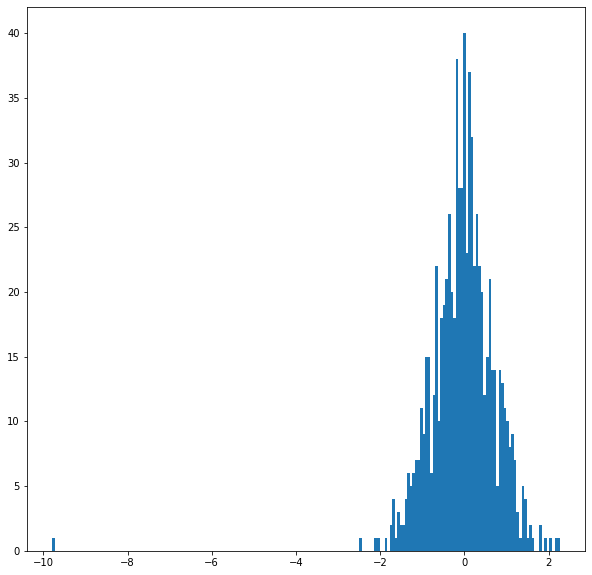

In [15]:
"""
一直不理解这里的想表示什么意思？
它想说的就是：我们把指定层的token的值拿出来【横坐标是token的值，纵坐标是token值对应
的个数。做了一个统计，就得到了如下的直方图。
这个直方图有一个特点就是：大致落在[-2,2]区间内，而且针对不同层的上述操作得到的直方图
大致相似】
"""
# For the 5th token in our sentence, 
# select its feature values from layer 5.
token_i = 2
layer_i = 6
print(batch_i) # batch[i] 值为0
vec = hidden_states[layer_i][batch_i][token_i]#[2]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [21]:
print('type of hidden_states:',type(hidden_states))
# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())


type of hidden_states: <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 22, 768])


In [16]:
token_embeddings = torch.stack(hidden_states,dim=0)
print(token_embeddings.size())

# 压缩第1个维度 => 就是batch 那个维度
token_embeddings = torch.squeeze(token_embeddings,dim=1)
print(token_embeddings.size())

token_embeddings = token_embeddings.permute(1,0,2)
print(token_embeddings.size())

torch.Size([13, 1, 22, 768])
torch.Size([13, 22, 768])
torch.Size([22, 13, 768])


In [24]:
# Creating word and sentence vectors from hidden states
"""现在既然已经得到了这些hidden states，那么该怎么操作？  主要目的有两个：
01.得到每个token 的 vector。
02.得到整个句子的单个vector 表示
对于每个token，在每层都有长度为768的向量。为了得到单独的向量表示，我们需要结合一些层
的vector来表示。但是哪些层能够提供最好的表示呢？
"""
token_vecs_cat = []
for token in token_embeddings:    
    # print(token.size()) # torch.Size([13,768])
    # token[-1] ~ token[-4] 得到的结果其实是一维数组的tensor，是1*768维。
    cat_vec = torch.cat((token[-1],token[-2],token[-3],token[-4]),dim=0)
    token_vecs_cat.append(cat_vec)
print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

tensor([-4.9644e-01, -1.8308e-01, -5.2314e-01,  5.2587e-01,  5.0757e-01,
         1.6377e-01,  2.0340e-01,  3.1712e-01, -5.3179e-02, -1.7396e-01,
         1.5662e-01, -2.9117e-01, -4.7011e-01,  6.4365e-01,  1.0168e-01,
         4.0403e-02, -2.2380e-01,  4.6682e-01,  7.8424e-01, -2.2906e-01,
        -1.1819e-01, -1.0461e-01,  2.0579e-01,  1.5623e-01, -3.3530e-02,
        -1.6434e-01, -3.0002e-01, -9.5776e-02, -9.0461e-02,  3.8368e-01,
         5.0868e-02,  5.7640e-02, -1.0336e-01, -8.3544e-01,  1.4537e-01,
        -3.9501e-01,  4.8040e-02, -1.4301e-01,  4.6877e-02,  3.0492e-01,
        -3.7933e-01,  8.9292e-02, -2.4666e-01,  4.7298e-02,  2.1082e-01,
        -6.7774e-01, -3.2265e+00, -7.8053e-02, -2.2076e-01, -2.9944e-01,
         8.0934e-02,  2.6543e-01, -1.8635e-01,  3.3911e-01, -2.9559e-01,
         1.0194e-01, -2.3794e-01,  3.4099e-01,  1.7350e-01,  6.4166e-02,
         2.1284e-01, -1.0288e-01,  6.6816e-02, -2.9052e-01, -5.8646e-01,
        -1.4075e-02,  9.1853e-02,  2.6041e-01, -3.4

In [34]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# token_embeddings is a [22 x 13 x 768] tensor.
# For each token in the sentence...
for token in token_embeddings:
    # `token` is a [13 x 768] tensor
    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

# 这样的操作之后，就得到了每个单词的（sum最后四层）的表示
print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))


torch.Size([22, 13, 768])
Shape is: 22 x 768


In [30]:
"""
下面来求 Sentence Vectors
"""
# 就是按照维度来取，没有什么其他复杂的。这里就相当于最外维的倒数第二层，然后是此外维的第1层
# 这里应该是hidden_states[-1][0] 啊？？？
# print(hidden_states.size())  hidden_states 是一个tuple

token_vecs = hidden_states[-2][0]  
print(token_vecs.size()) # torch.Size([22,768])
sentence_embedding = torch.mean(token_vecs,dim=0)


AttributeError: 'tuple' object has no attribute 'size'

In [32]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


In [37]:
print('First 5 vector values for each instance of "bank".')
print('')
# 因为是22*768维，所以这里简化输出，只输出22*3
print("bank vault   ", str(token_vecs_sum[6][:3])) 
print("bank robber  ", str(token_vecs_sum[10][:3]))
print("river bank   ", str(token_vecs_sum[19][:3]))


First 5 vector values for each instance of "bank".

bank vault    tensor([ 3.3596, -2.9805, -1.5421])
bank robber   tensor([ 2.7359, -2.5577, -1.3094])
river bank    tensor([ 1.5266, -0.8895, -0.5152])


In [38]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[19])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.94
Vector similarity for *different* meanings:  0.69
